In [ ]:
!pip install -q -q -q Cython

In [35]:
%matplotlib inline

In [36]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [37]:
import numpy as np
import pandas as pd

from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt
from matplotlib import cm

In [38]:
%%cython


import numpy as np
cimport numpy as cnp
import cython
cnp.import_array()
@cython.boundscheck(False)
@cython.wraparound(False)
def convofc(cnp.ndarray[long, ndim=1] I, 
            cnp.ndarray[long, ndim=1] J, 
            cnp.ndarray[double, ndim=1] W, 
            cnp.ndarray[double, ndim=2, mode='c'] kernel, 
            cnp.ndarray[double, ndim=2, mode='c'] resf):
    cdef:
        ssize_t ki, kj,i, j, ii, jj, si, sj, kki, kkj
    ki = int(np.floor(kernel.shape[0]/2))
    kj = int(np.floor(kernel.shape[1]/2))
    si = int(resf.shape[0])
    sj = int(resf.shape[1])
    kki = int(kernel.shape[0])
    kkj = int(kernel.shape[1])
    for n in range(len(I)):
        for i in range(kki):
            ii = int(i - ki + I[n])
            if (ii>=0) & (ii<(si)):
                
                for j in range(kkj):
                
                    jj = int(j - kj + J[n])
                    if (jj>=0) & (jj<sj):
                        
                        resf[ii,jj] = resf[ii, jj] + kernel[i,j] * W[n]
    return(resf)


In [ ]:
def build_kernel(r,step):
    size = np.ceil(r / step) 
    if (size%2)==0:
        size=size+3
    else:
        size = size + 2
    
    XY = np.arange(size) * step - (r/2)
    X, Y = np.meshgrid(XY, XY,  indexing='ij')
    kernel = X**2 + Y**2 
    kernel = (1- (kernel/(r**2)))**2 * (kernel<=(r/2)**2)
    return(kernel) 

In [ ]:
def cpc(rs, sigma=0.05, granularity=5):
    step = np.min(rs)/granularity
    toto = np.ceil((1/step)).astype(int)
    resf = np.zeros((toto,toto))

    N = rng.poisson(-np.log(rs)*100).astype(int)
    Xy = rng.uniform(size=(np.sum(N),2))
    W = rng.normal(size=np.sum(N), scale=sigma)
    rsN = np.repeat(rs,N).reshape(np.sum(N),)
    
    I = np.floor(Xy[:, 0] / step).astype(int)
    J = np.floor(Xy[:, 1] / step).astype(int)
    
    for r in rs:
        kernel = build_kernel(r, step)
        resf = convofc(I[rsN==r], J[rsN==r], W[rsN==r], kernel.astype(float), resf.astype(float))
    
    return(np.exp(resf))

### Exemples coumpund poisson cascade

In [39]:
rs =  0.5 * (1/np.power(2, 1/4)) ** np.arange(0,21)

In [40]:
cpc(rs).shape

(320, 320)

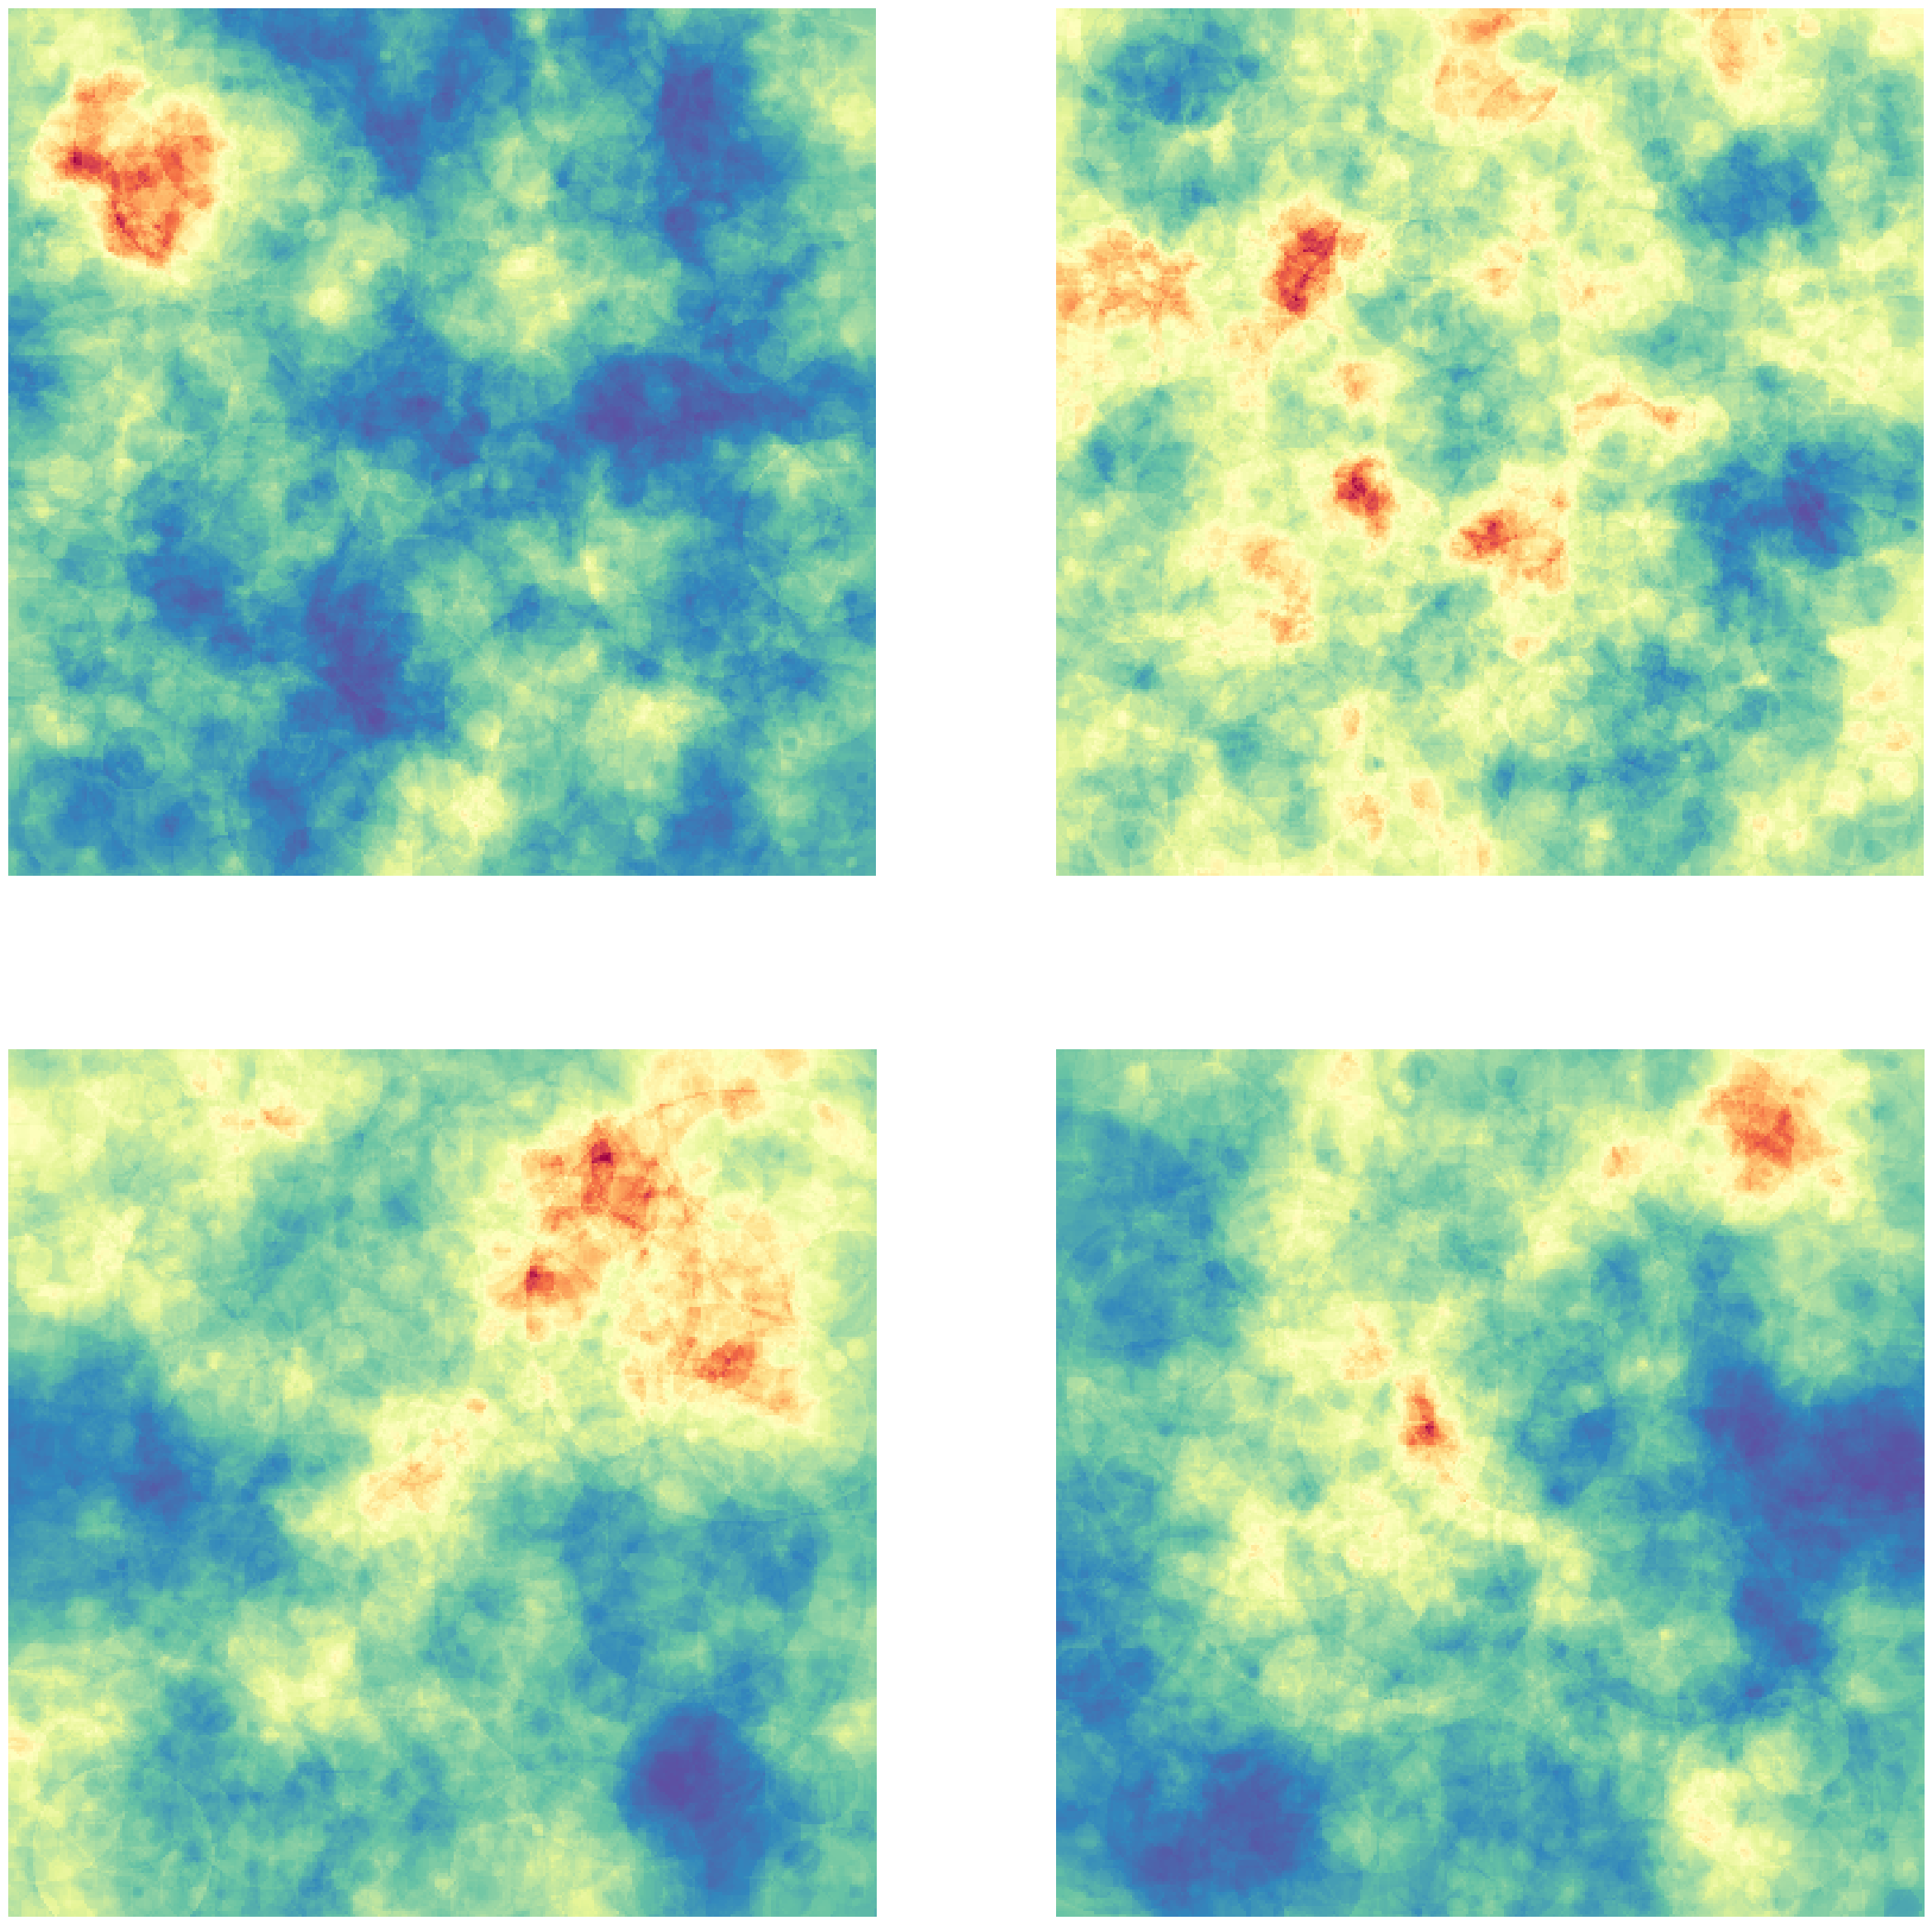

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(30,30))
for ax in axs.flat:
    ax.imshow(cpc(rs), cmap=cm.Spectral_r)
    ax.set_axis_off()


### Joint cpc

In [42]:
def jcpc(rs, sigma=0.05, l=0.5, granularity=5):
    step = np.min(rs)/granularity
    toto = np.ceil((1/step)).astype(int)
    resf1 = np.zeros((toto,toto))
    resf2 = np.zeros((toto,toto))
           
    N = rng.poisson(-np.log(rs)*100).astype(int)
    Xy = rng.uniform(size=(np.sum(N),2))
    
    W = rng.multivariate_normal(np.array([0,0]),
                        sigma * np.array([[1,l],
                                  [l, 1]]), np.sum(N))
    
    rsN = np.repeat(rs,N).reshape(np.sum(N),)
    
    I = np.floor(Xy[:, 0] / step).astype(int)
    J = np.floor(Xy[:, 1] / step).astype(int)
    
    for r in rs:
        kernel = build_kernel(r, step)
        resf1 = convofc(I[rsN==r], J[rsN==r], W[rsN==r,0], kernel.astype(float), resf1.astype(float))
        resf2 = convofc(I[rsN==r], J[rsN==r], W[rsN==r,1], kernel.astype(float), resf2.astype(float))
        
    return((np.exp(resf1), np.exp(resf2)))

In [61]:
for l in np.arange(-0.9,1,0.1):
    fractal = np.stack(jcpc(rs, l =0.3), axis=-1)

In [65]:
test = np.stack([np.stack(jcpc(rs, l =0.3), axis=-1) for l in np.arange(-0.9,1,0.1)])

In [66]:
np.savez_compressed('test_fractal.npy', test)

In [76]:
np.savez_compressed('test_fractal.npy', np.float32(test))